# Clasificador de sentmientos
Procesamiento de Lenguaje Natural

**Universidad Internacional de la Rioja**
- Jose Miguel Chacón
- Sonia Tarazona
- Carlos Giraldo

En este notebook se construirá un clasificador de sentimientos para solicitudes de usuarios en el sector bancario.
Los pasos a seguir son:

- Empezar con el clasificador de sentimientos más popular el el hub de Huging Face, que ha sido ajustado con el dataset SST2.
- Etiquetar un dataset de entrenamiento con preguntas de usuarios del sector bancario comenzando con el clasificador de sentimientos preentrenado.
- Ajustar el clasificador preentrenado con nuestro dataset de entrenamiento.
- Etiquetar más datos para corregir las predicciones del modelo ajustado
- Ajustar el clasificador preentrenado con el dataset extendido 

## Instalación de dependencias

In [ ]:
%pip install loguru
%pip install "rubrix[server]" 
%pip install transformers[torch] datasets sklearn ipywidgets -qqq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.


## Configuración inicial
Carga del modelo preentrenado y el dataset

### Banking77
Este dataset contiene preguntas de usuarios online en el sector bancario y sus correspondientes intenciones. En este caso etiquetaremos los sentimientos asociados a estas preguntas, esto puede ser útil para asistentes digitales y distintas analíticas de servicio al cliente.

In [ ]:
from datasets import load_dataset
import rubrix as rb

In [ ]:
# Se cargará el dataset directamentee del hub y se dividirá en 50 subconjuntos.
# Empezaremos con el conjunto to_label1 para exploración y anotación de la data, y mantendremos to_label2 para siguientes iteraciones. 

banking_ds = load_dataset("banking77")

to_label1, to_label2 = banking_ds['train'].train_test_split(test_size=0.5, seed=42).values()

2022-06-05 15:26:14.088 | WARNING  | datasets.builder:_create_builder_config:412 - Using custom data configuration default
2022-06-05 15:26:14.092 | WARNING  | datasets.builder:download_and_prepare:577 - Reusing dataset banking77 (/Users/josemiguel/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

2022-06-05 15:26:14.140 | WARNING  | datasets.arrow_dataset:train_test_split:3426 - Loading cached split indices for dataset at /Users/josemiguel/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b/cache-3ee5b5f39e7a6029.arrow and /Users/josemiguel/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b/cache-3613c7618531b684.arrow


### Modelo
El modelo que cargaremos, *DistilBERT* se trata de un modelo basado en la arquitectura BERT, más pequeño y rápido. Está ajustado sobre el SST, un punto de referencia de clasificación de sentimientos muy popular. Sin embargo, al ser un clasificador de propósito general es necesario ajustarlo para casos específicos y estilos de texto. Exploraremos su calidad en el caso de preguntas de usuarios bancarios y construiremos un dataset de entrenamiento para adaptarlo a este dominio.

In [ ]:
from transformers import pipeline

sentiment_classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    task="sentiment-analysis",
    return_all_scores=True,
)

to_label1[3]['text'], sentiment_classifier(to_label1[3]['text'])

('Hi, Last week I have contacted the seller for a refund as directed by you, but i have not received the money yet. Please look into this issue with seller and help me in getting the refund.',
 [[{'label': 'NEGATIVE', 'score': 0.9934700727462769},
   {'label': 'POSITIVE', 'score': 0.0065299286507070065}]])

En este ejemplo el modelo dio más probabilidad a la clase *NEGATIVO*.  Siguiendo la política de anotación, más ejemplos similares serán anotados cómo *POSITIVO* siendo preguntas generales, que no están relacionadas con el funcionamiento del banco. El objetivo principal es ajustar el modelo para predecir cómo *POSITIVO* estos casos.

**Nota:** El análisis de sentimientos es una de las tareas más subjetivas en el campo del NLP. Lo que entendemos como sentimiento puede variar de una aplicación a otra dependiendo de los objetivos de negocio del proyecto. También, los sentimientos pueden ser modelados de distintas maneras, generando diferentes esquemas de etiquetado.
Por ejemplom un sentimiento puede ser modelado cómo un valor real (desde -1 a 1 o desde 0 a 1.0) o con 2 o más etiquetas (incluyendo grados cómo psitivo, negativo, neutral, etc)

Para este caso se usará el esquema original definido por el modelo preentrenado que está compuesto por dos etiquetas: *POSITIVO* y *NEGATIVO*.

Otro elemento importante cuándo se realiza data anottation son las guías de anotación, que explican cómo asignar las etiquetas a ejemplos espefícos. Cómo veremos más adelante, los mensajes que etiquetaremos son mayoritariamente con un sentimiento neutro, los cuales clasificaremos como positivos, mientras existen otros mensajes negativos que etiquetaremos cómo tal.

## 1. Ejecutar el modelo preentrenado sobre el dataset y monitorear las predicciones
Podemos usar el modelo preentrenado para realizar predicciones sobre el dataset en crudo, esto gracias al método dataset.map de la librería datasets.

In [ ]:
def predict(examples):
    return {"predictions": sentiment_classifier(examples['text'], truncation=True)}

to_label1 = to_label1.map(predict, batched=True, batch_size=4)

  0%|          | 0/1251 [00:00<?, ?ba/s]

### Crear registros

In [ ]:
# Se crea una lista de registros con las predicciones

records = []
for example in to_label1.shuffle():
    record = rb.TextClassificationRecord(
        text=example["text"],
        metadata={'category': example['label']}, # log the intents for exploration of specific intents
        prediction=[(pred['label'], pred['score']) for pred in example['predictions']],
        prediction_agent="distilbert-base-uncased-finetuned-sst-2-english"
    )
    records.append(record)

In [ ]:
# Esta pieza almacena los registros en el hub de Huggin Face, esto nos permite guardar una versión de él con las predicciones, 
# para que no debamos correr el modelo preentrenado nuevamente.

dataset_rb = rb.DatasetForTextClassification(records)
dataset_ds = dataset_rb.to_datasets()

dataset_ds.push_to_hub("JoseMiguel/sa")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Descarga del dataset desde HugingFace

dataset_ds = load_dataset("JoseMiguel/sa", split="train")
dataset_rb = rb.read_datasets(dataset_ds, task="TextClassification")

Downloading:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

2022-06-05 15:28:38.417 | WARNING  | datasets.builder:_create_builder_config:412 - Using custom data configuration JoseMiguel--sa-aa6032e2f1b5f48e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /Users/josemiguel/.cache/huggingface/datasets/JoseMiguel___parquet/JoseMiguel--sa-aa6032e2f1b5f48e/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


In [ ]:
# Con esta instruccion montamos el dataset al servidor local de Rubrix para explorar y etiquetar el dataset.
rb.log(dataset_rb, name='labeling_with_pretrained')

  0%|          | 0/5001 [00:00<?, ?it/s]

5001 records logged to http://localhost:6900/datasets/rubrix/labeling_with_pretrained


BulkResponse(dataset='labeling_with_pretrained', processed=5001, failed=0)

## 2. Explorar y etiquetar la data con el modelo preentrenado

En este paso empezaremos por explorar cómo el modelo preentrenado se comporta con nuestro dataset.
Inicialmente:
- El clasificador de sentimientos preentrenado tiende a clasificar la mayor parte de los ejemplos cómo NEGATIVOS (4.835 de 5.001 registros)
- Al ver los ejemplos clasificados cómo positivos, podemos ver que según nuestra "política de anotación" muchos de estos no están clasificados correctamente. Por ejemplo "I didn’t withdraw the amount of cash that is showing up in the app.” en español "No retiré la cantidad de efectivo que aparece en la aplicación".

Teniendo en cuenta esto, podemos etiquetar adecuadamente nuestros datos usando la interfaz de usuario de Rubrix, con la siguiente instrucción

Cantidad de ejemplos clasificados por cada clase:

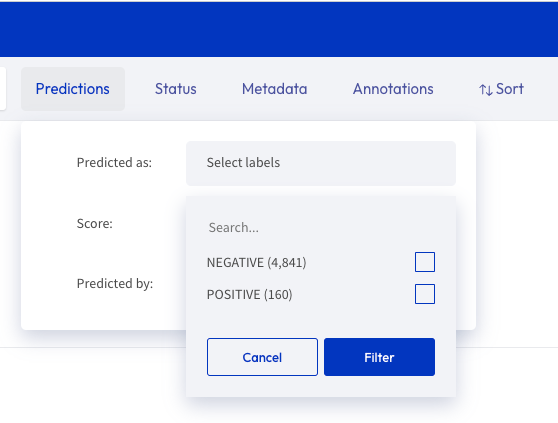

Ejemplo clasificado cómo positivo:

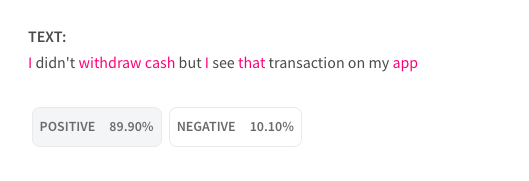

In [ ]:
# Imagen de docker con elasticsarch - Primera vez
!docker run -d --name elasticsearch-for-rubrix -p 9200:9200 -p 9300:9300 -e "ES_JAVA_OPTS=-Xms512m -Xmx512m" -e "discovery.type=single-node"  docker.elastic.co/elasticsearch/elasticsearch-oss:7.10.2
# Una vez la imagen esté descargada 
!docker start elasticsearch-for-rubrix
# Correr Rubrix server
!python -m rubrix 

El flujo de trabajo es el siguiente
1. Usando la interfaz, en este caso etiquetaremos los ejemplos secuencialmente (uno detrás de otro).
2. Una vez familiarizados con los datos, usaremos filtros para anotar ejemplos con etiquetas específicas. En este caso, Etiquetaremos ejemplos predichos como positivos por el modelo preentrenado y luego algunos ejemplos predichos cómo negativos.


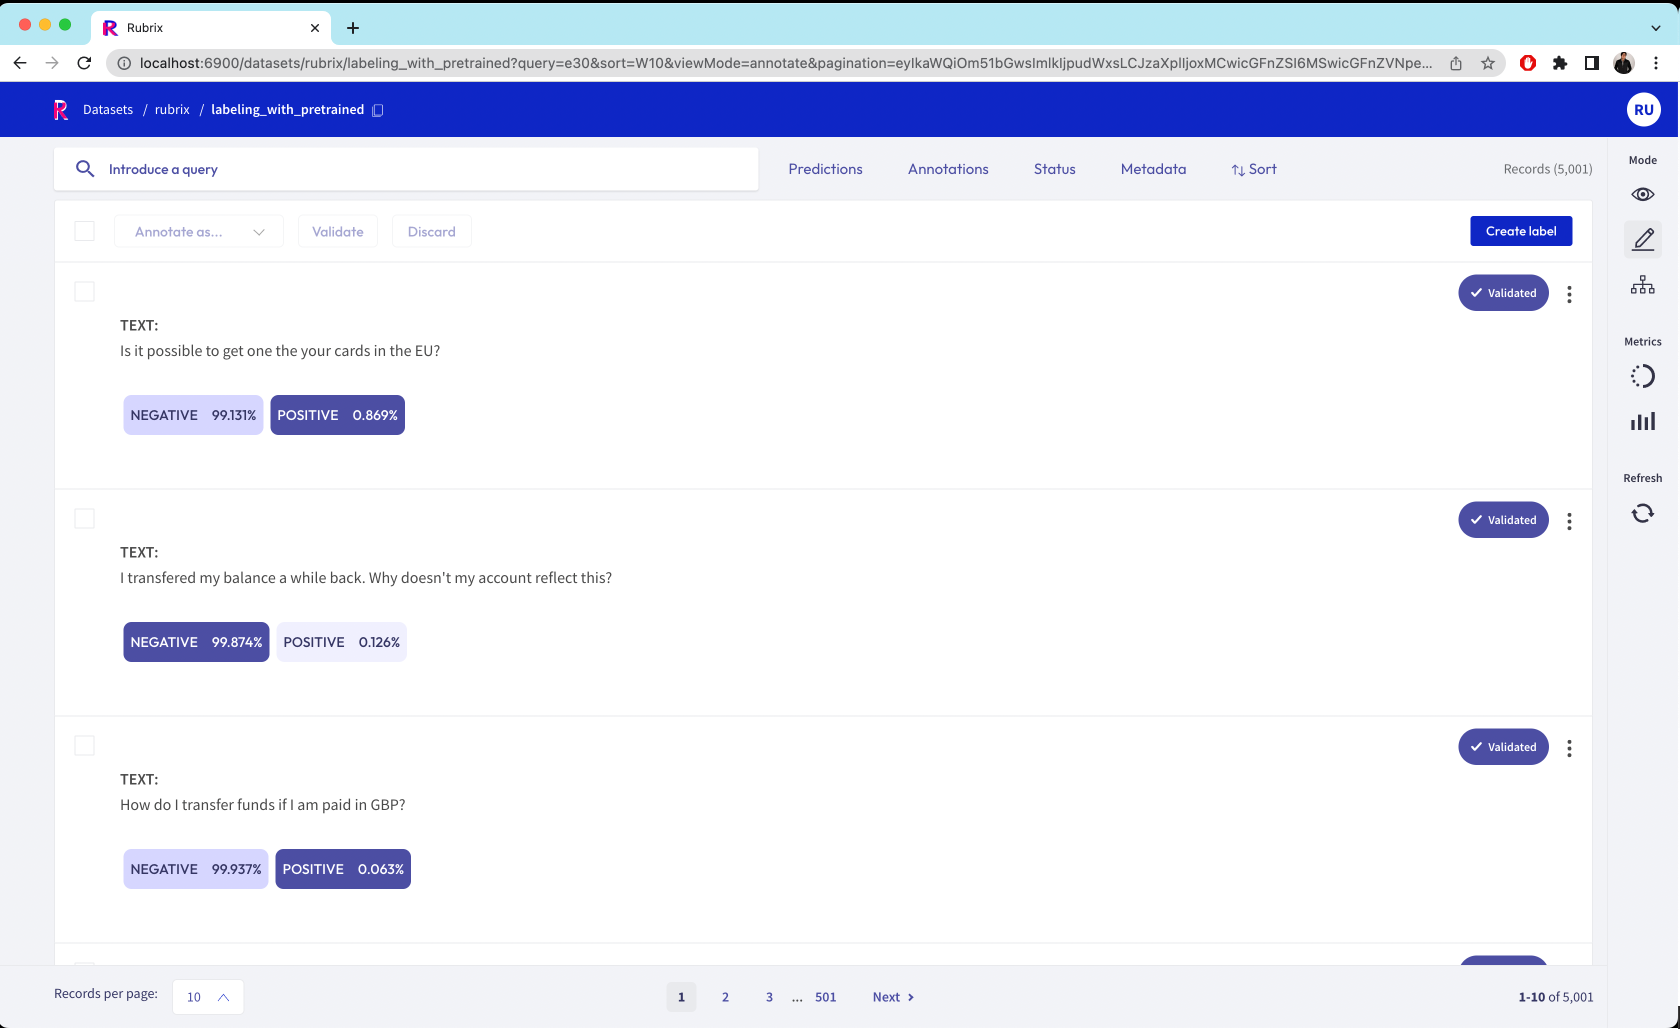

## 3. Ajustar el modelo preentrenado

En este paso cargaremos el dataset modificado desde Rubrix y luego lo ajustaremos usando el Trainer API de la librería transformers de Huggin Face. 

In [ ]:
# Cargamos el dataset filtrando por los que acabamos de validar

rb_dataset = rb.DatasetForTextClassification.from_pandas(rb.load(name='labeling_with_pretrained', query="status:Validated"))
rb_dataset.to_pandas().head(3)

2022-06-05 17:29:41.619 | WARNING  | rubrix.client.api:load:461 - The argument 'as_pandas' in `rb.load` will be deprecated in the future, and we will always return a `Dataset`. To emulate the future behavior set `as_pandas=False`. To get a pandas DataFrame, call `Dataset.to_pandas()`


,text,inputs,prediction,prediction_agent,annotation,annotation_agent,multi_label,explanation,id,metadata,status,event_timestamp,metrics,search_keywords
0,How long do money transfers take? My friend re...,{'text': 'How long do money transfers take? My...,"[(NEGATIVE, 0.9995788931846619), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,NEGATIVE,rubrix,False,None,00059b91-5095-4afe-9f4b-20a6a25332c5,{'category': 66},Validated,None,{'text_length': 119},None
1,let me know how many disposable cards I can have?,{'text': 'let me know how many disposable card...,"[(NEGATIVE, 0.9995052814483643), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,0016a521-992d-424f-ac77-efd0d42c3b52,{'category': 29},Validated,None,{'text_length': 49},None
2,I received my salary in the wrong currency. Ho...,{'text': 'I received my salary in the wrong cu...,"[(NEGATIVE, 0.9996384382247925), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,rubrix,False,None,00177f14-3039-4d9d-b2bd-1ae7fe41584b,{'category': 50},Validated,None,{'text_length': 65},None


Preparamos el dataset para el entrenamiento y test de nuestro clasificador de sentmientos.

In [ ]:
# create 🤗 dataset with labels as numeric ids
train_ds = rb_dataset.prepare_for_training()

In [ ]:
from transformers import AutoTokenizer

# tokenize our datasets
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_ds = train_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Dividimos los datos en entrenamiento y test
train_dataset, eval_dataset = tokenized_train_ds.train_test_split(test_size=0.2, seed=42).values()

### Entrenamiento
Cargamos el modelo preentrenado *distilbert-base-uncased-finetuned-sst-2-english*

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
# Configuración del objeto de entrenamiento - Trainer
import numpy as np
from transformers import Trainer
from datasets import load_metric
from transformers import TrainingArguments

training_args = TrainingArguments(
    "distilbert-base-uncased-sentiment-banking",
    evaluation_strategy="epoch",
    logging_steps=30,
)

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Entrenamiento del modelo
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/Caskroom/miniforge/base/envs/rubrix/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


  0%|          | 0/6 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.814049243927002, 'eval_accuracy': 0.5, 'eval_runtime': 0.5061, 'eval_samples_per_second': 7.903, 'eval_steps_per_second': 1.976, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.6471489667892456, 'eval_accuracy': 0.5, 'eval_runtime': 0.4953, 'eval_samples_per_second': 8.076, 'eval_steps_per_second': 2.019, 'epoch': 2.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.5440986156463623, 'eval_accuracy': 0.5, 'eval_runtime': 0.5277, 'eval_samples_per_second': 7.58, 'eval_steps_per_second': 1.895, 'epoch': 3.0}
{'train_runtime': 24.1849, 'train_samples_per_second': 1.985, 'train_steps_per_second': 0.248, 'train_loss': 1.2937000592549641, 'epoch': 3.0}


TrainOutput(global_step=6, training_loss=1.2937000592549641, metrics={'train_runtime': 24.1849, 'train_samples_per_second': 1.985, 'train_steps_per_second': 0.248, 'train_loss': 1.2937000592549641, 'epoch': 3.0})

## 4. Test del modelo ajustado

In [ ]:
finetuned_sentiment_classifier = pipeline(
    model=model.to("cpu"),
    tokenizer=tokenizer,
    task="sentiment-analysis",
    return_all_scores=True
)

In [ ]:
# Comparamos los resultados del primer modelo y el que acabamos de entrenar
finetuned_sentiment_classifier(
    'I need to deposit my virtual card, how do i do that.'
), sentiment_classifier(
    'I need to deposit my virtual card, how do i do that.'
)

([[{'label': 'NEGATIVE', 'score': 0.1484106183052063},
   {'label': 'POSITIVE', 'score': 0.8515893220901489}]],
 [[{'label': 'NEGATIVE', 'score': 0.9992493987083435},
   {'label': 'POSITIVE', 'score': 0.0007506068795919418}]])

In [ ]:
finetuned_sentiment_classifier(
    'Why is my payment still pending?'
), sentiment_classifier(
    'Why is my payment still pending?'
)

([[{'label': 'NEGATIVE', 'score': 0.8916626572608948},
   {'label': 'POSITIVE', 'score': 0.10833735018968582}]],
 [[{'label': 'NEGATIVE', 'score': 0.9983781576156616},
   {'label': 'POSITIVE', 'score': 0.0016218494856730103}]])

Vemos que el modelo ajustado con el último dataset cumple su objetivo (primer ejemplo) y además, se diferencia del primero; esto con sólo ajustar 20 etiquetas en rubrix.

## 5. Correr el modelo ajustado sobe el dataset

In [ ]:
# Ahora cargamos este modelo al servidor de Rubrix para explorarlo
rb_dataset = rb.DatasetForTextClassification.from_pandas(rb.load(name='labeling_with_pretrained', query="status:Default"))


In [ ]:
def predict(examples):
    texts = [example["text"] for example in examples["inputs"]]
    return {
        "prediction": finetuned_sentiment_classifier(texts),
        "prediction_agent": ["distilbert-base-uncased-banking77-sentiment"]*len(texts)
    }

ds_dataset = rb_dataset.to_datasets().map(predict, batched=True, batch_size=8)

  0%|          | 0/623 [00:00<?, ?ba/s]

In [ ]:
records = rb.read_datasets(ds_dataset, task="TextClassification")

rb.log(records=records, name='labeling_with_finetuned')

  0%|          | 0/4981 [00:00<?, ?it/s]

4981 records logged to http://localhost:6900/datasets/rubrix/labeling_with_finetuned


BulkResponse(dataset='labeling_with_finetuned', processed=4981, failed=0)

## 6. Exploración y etiquetado de datos con el modelo ajustado

En este paso exploraremos cómo el modelo ajustado está trabajando con nuestro dataset.
En primera instancia, usando los filtros de POSITIVO y luego NEGATIVO, podemos ver que los resultados están más en línea con la política de etiquetado, que definimos al comienzo.

Ahora que el modelo se comporta mejor para nuestro caso específico, extenderemos nuestro set de entrenamiento con ejemplos muy informativos, el flujo es el siguiente:
- Usar el filtro de "puntaje" para etiquetar ejemplos más inciertos.
- Etiquetar ejemplos predichos cómo POSITIVOS y luego cómo NEGATIVOS para corregir la clasificación.

Se hace este ejercicio con 80 ejemplos, 2% del dataset:

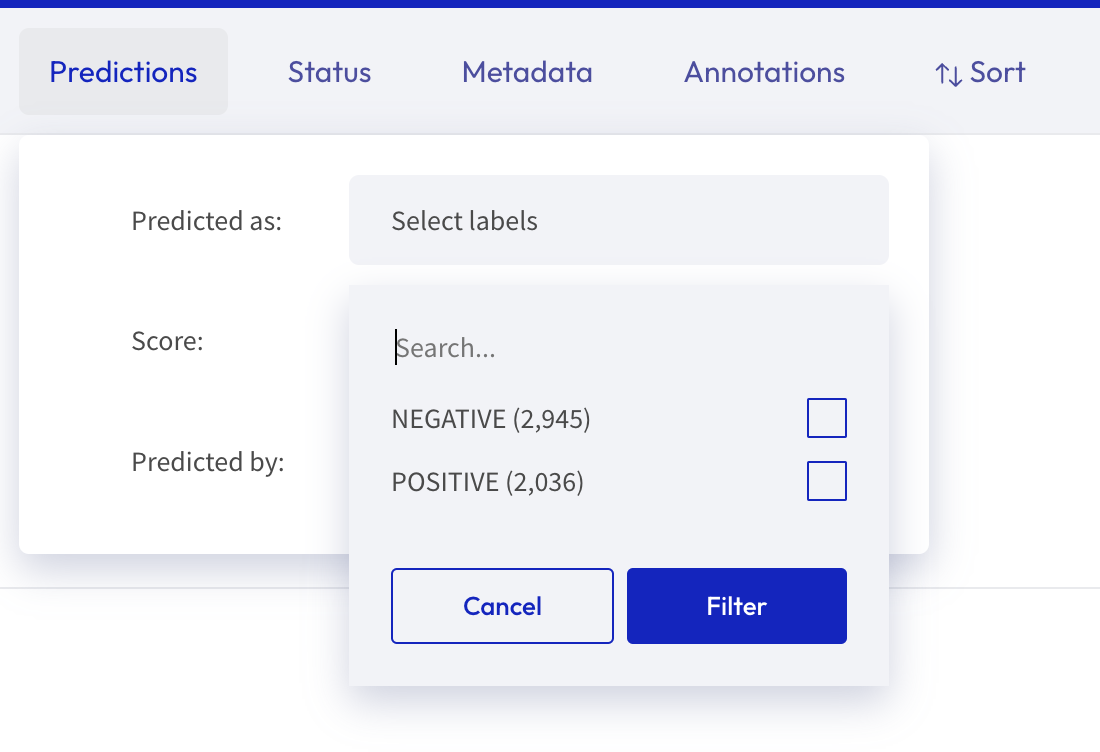

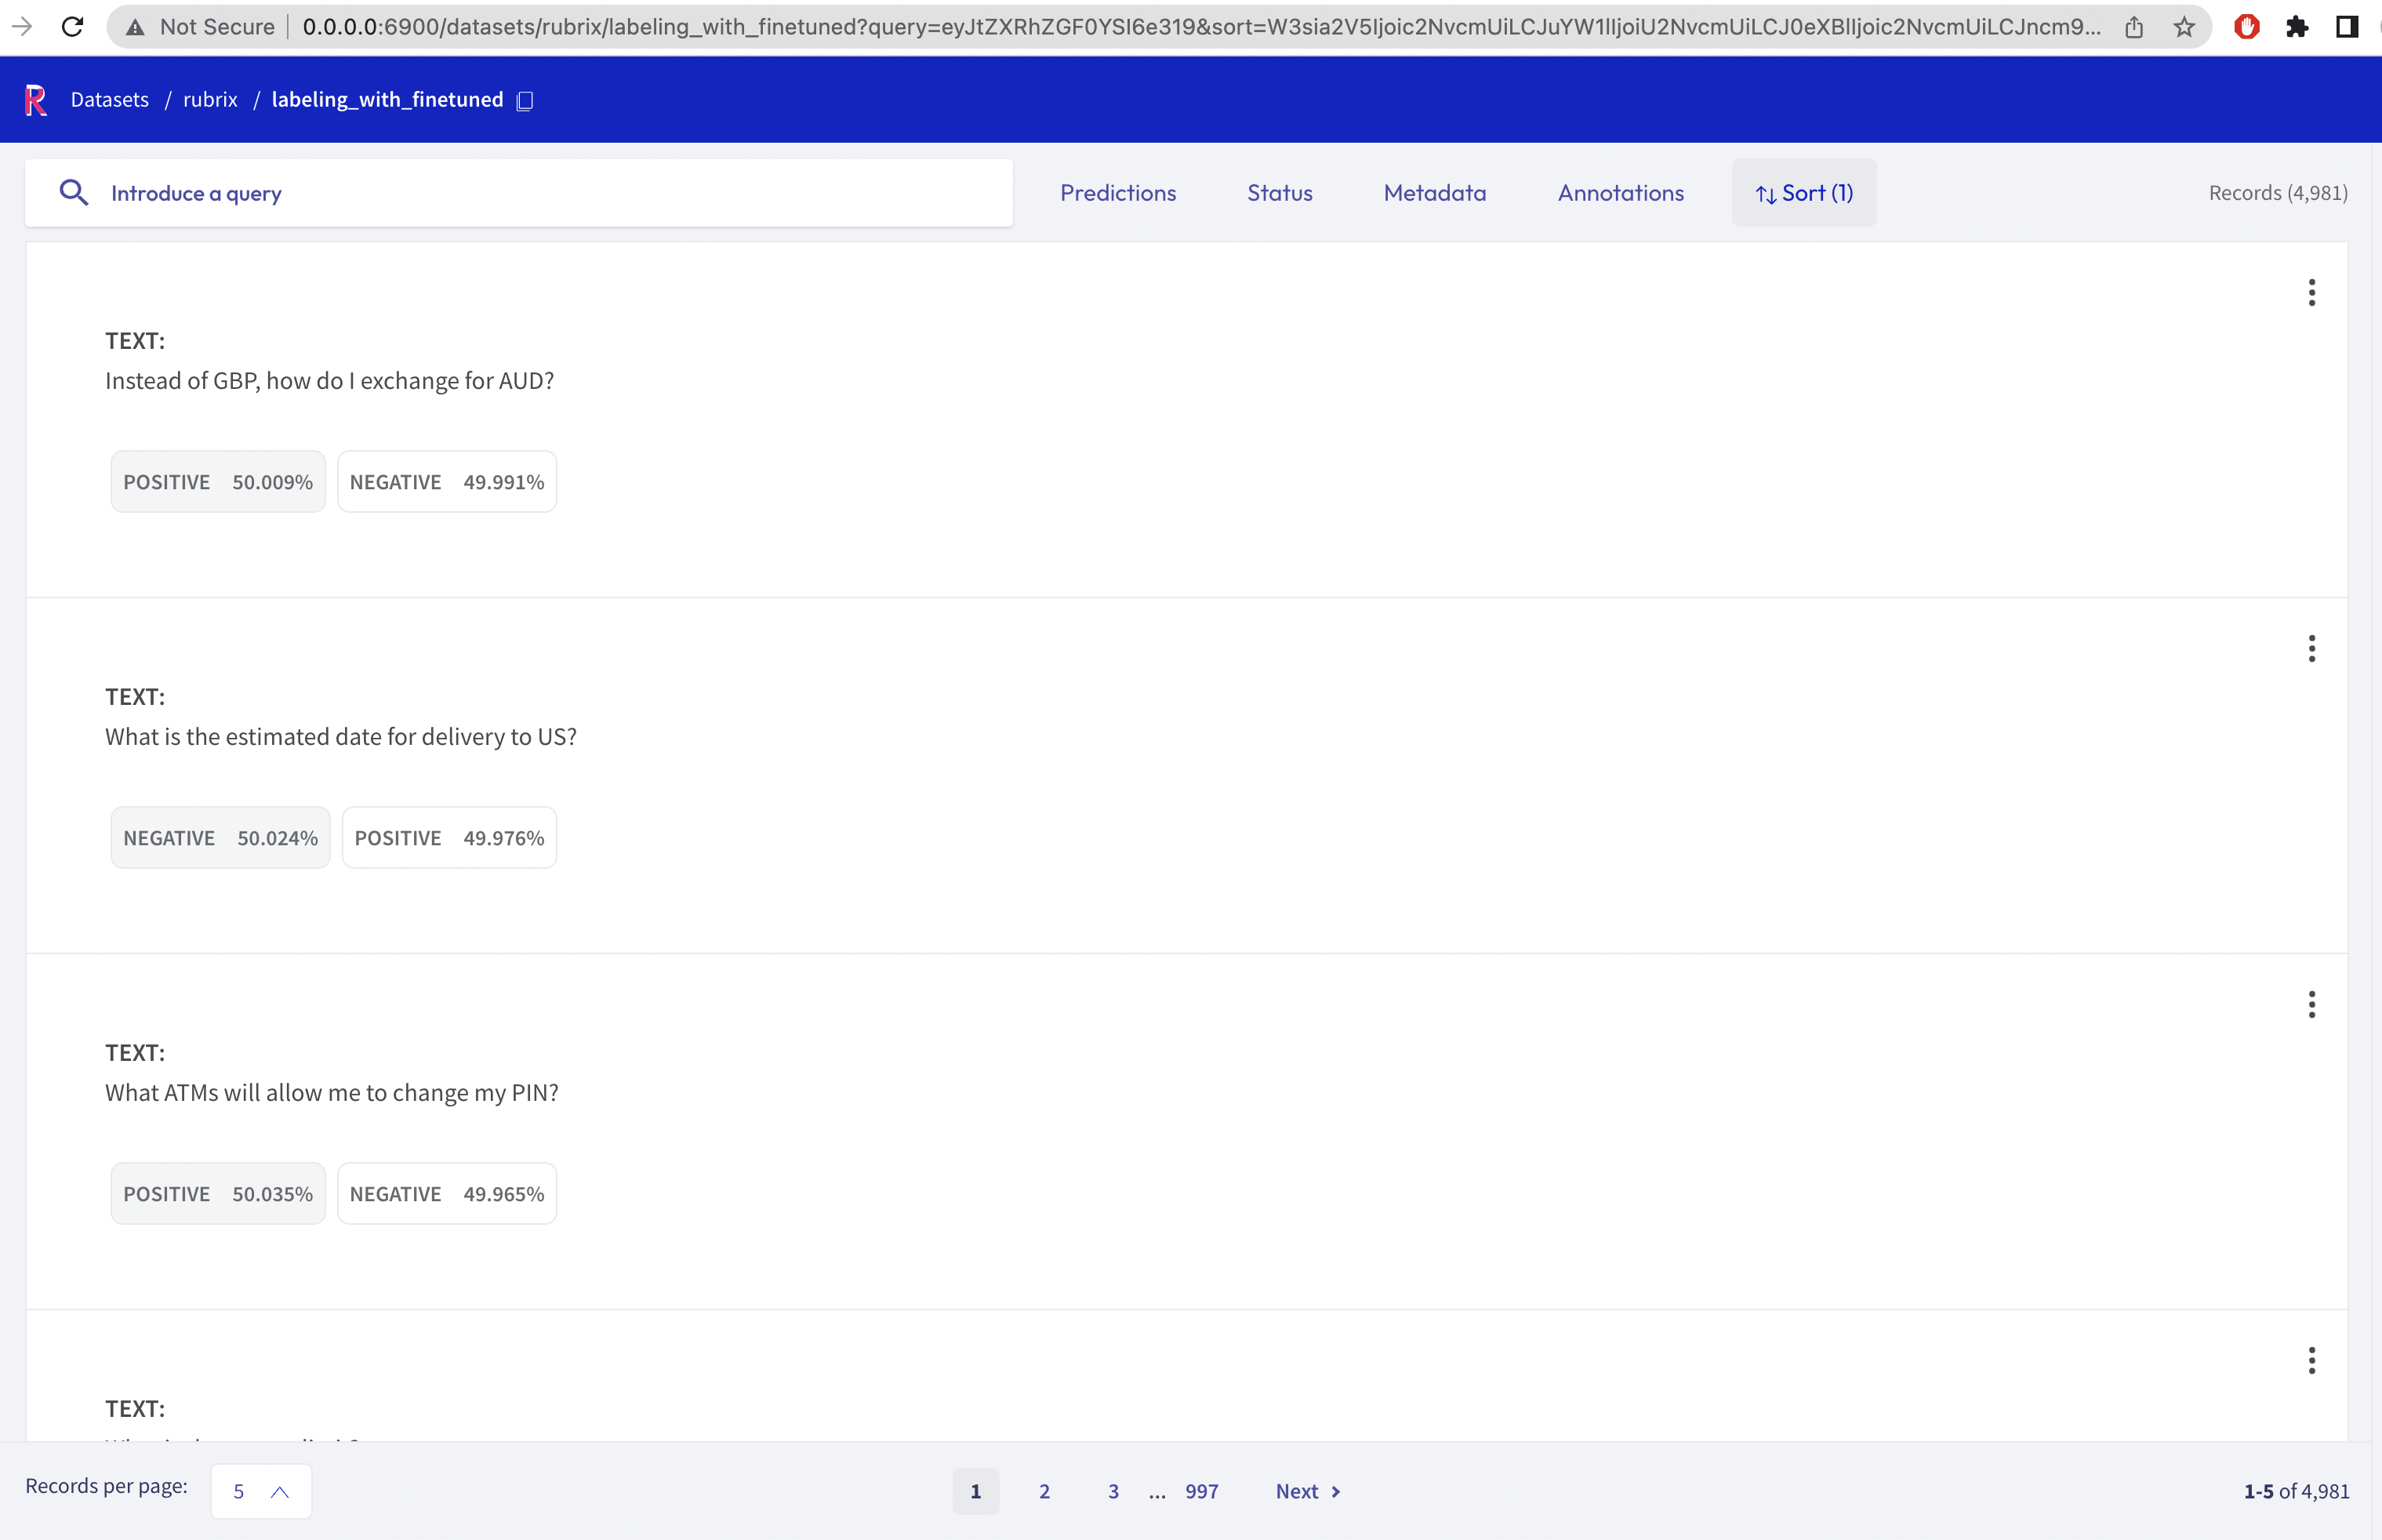

In [ ]:
rb_dataset = rb.DatasetForTextClassification.from_pandas(rb.load(name='labeling_with_finetuned', query="status:Validated"))
print(rb_dataset.to_pandas().shape) # 80 registros
rb_dataset.to_pandas().head(3)

(80, 14)


,text,inputs,prediction,prediction_agent,annotation,annotation_agent,multi_label,explanation,id,metadata,status,event_timestamp,metrics,search_keywords
0,There is a direct debit transaction that I did...,{'text': 'There is a direct debit transaction ...,"[(NEGATIVE, 0.5132977962493896), (POSITIVE, 0....",distilbert-base-uncased-banking77-sentiment,NEGATIVE,rubrix,False,None,01ce86cc-b515-4d64-b798-5052ecd7266b,{'category': 28},Validated,None,{'text_length': 60},None
1,How do I get a spare card?,{'text': 'How do I get a spare card?'},"[(NEGATIVE, 0.5257774591445923), (POSITIVE, 0....",distilbert-base-uncased-banking77-sentiment,POSITIVE,rubrix,False,None,055d1c0a-cd03-4fc0-b455-7232a7fa32cf,{'category': 39},Validated,None,{'text_length': 26},None
2,I want to return an item for a refund can I do...,{'text': 'I want to return an item for a refun...,"[(NEGATIVE, 0.5115370154380798), (POSITIVE, 0....",distilbert-base-uncased-banking77-sentiment,POSITIVE,rubrix,False,None,0a291706-55fe-4b70-a57d-4fb11f8e5360,{'category': 52},Validated,None,{'text_length': 52},None


## 7. Ajuste con el dataset extendido

In [ ]:
# Agregamos los nuevos ejemplos al dataset de entrenamiento anterior
rb_dataset = rb.DatasetForTextClassification.from_pandas(rb.load("labeling_with_finetuned"))

train_ds = rb_dataset.prepare_for_training()
tokenized_train_ds = train_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# Concatenamos
from datasets import concatenate_datasets

train_dataset = concatenate_datasets([train_dataset, tokenized_train_ds])

### Entrenar el clasificador de sentimientos 

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

loading configuration file https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json from cache at /Users/josemiguel/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  

In [ ]:
train_ds = train_dataset.shuffle(seed=42)

trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/Caskroom/miniforge/base/envs/rubrix/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 96
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


  0%|          | 0/36 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7293516397476196, 'eval_accuracy': 0.75, 'eval_runtime': 0.594, 'eval_samples_per_second': 6.734, 'eval_steps_per_second': 1.684, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9410037398338318, 'eval_accuracy': 0.75, 'eval_runtime': 0.5032, 'eval_samples_per_second': 7.949, 'eval_steps_per_second': 1.987, 'epoch': 2.0}
{'loss': 0.5261, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.1898014545440674, 'eval_accuracy': 0.75, 'eval_runtime': 0.4988, 'eval_samples_per_second': 8.02, 'eval_steps_per_second': 2.005, 'epoch': 3.0}
{'train_runtime': 143.8716, 'train_samples_per_second': 2.002, 'train_steps_per_second': 0.25, 'train_loss': 0.4585523373550839, 'epoch': 3.0}


TrainOutput(global_step=36, training_loss=0.4585523373550839, metrics={'train_runtime': 143.8716, 'train_samples_per_second': 2.002, 'train_steps_per_second': 0.25, 'train_loss': 0.4585523373550839, 'epoch': 3.0})

Acá vemos que el accuracy del modelo mejora de 0.5 a 0.75 en los datos de test.

In [ ]:
# Guardamos el modelo para su posterior uso
model.save_pretrained("distilbert-base-uncased-sentiment-banking")

Configuration saved in distilbert-base-uncased-sentiment-banking/config.json
Model weights saved in distilbert-base-uncased-sentiment-banking/pytorch_model.bin
